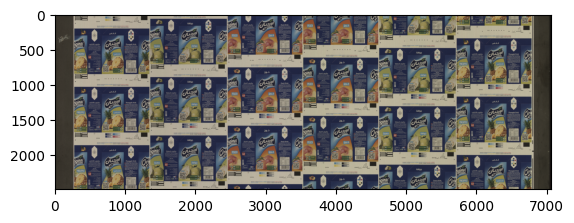

In [1]:
import cv2
from matplotlib import pyplot as plt

path = '/Users/USER/Desktop/HACKATHON/data/Job1.bmp'
im = cv2.imread(path)
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im_rgb)
plt.show()

In [2]:
import fitz
import os
 
def pdf_to_jpg(pdf_path, output_folder, zoom_x=2.0, zoom_y=2.0):
    pdf_document = fitz.open(pdf_path)
 
    # Create a zoom matrix to increase resolution
    mat = fitz.Matrix(zoom_x, zoom_y)
 
    for page_number in range(pdf_document.page_count):
        page = pdf_document[page_number]
        image = page.get_pixmap(matrix=mat)  # apply the zoom matrix
 
        jpg_filename = os.path.join(output_folder, f'page_{page_number + 3}.jpg')
        image.save(jpg_filename)
 
    pdf_document.close()

# Usage example
pdf_path = '/Users/USER/Desktop/HACKATHON/samples/SA-A073.pdf'  # Replace 'input.pdf' with the path to your PDF file
output_folder = '/Users/USER/Desktop/HACKATHON/samples_images'  # Output folder where JPG images will be saved
os.makedirs(output_folder, exist_ok=True)

pdf_to_jpg(pdf_path, output_folder)


In [3]:
import pytesseract

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [4]:
import numpy as np

def decode_predictions(scores, geometry):
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        for x in range(0, numCols):
            if scoresData[x] < 0.5:
                continue

            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    return (rects, confidences)

def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
    if len(boxes) == 0:
        return []

    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    pick = []

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(probs)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    return boxes[pick].astype("int")


Extracted ID: SA-AQ73-15-P2746 SA-AQ73-25-B0083 |
Corrected ID: SA-A073


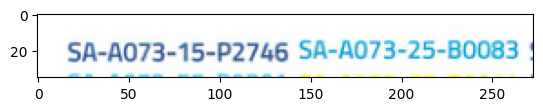

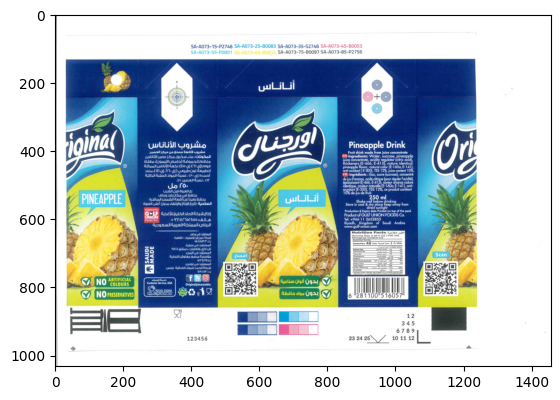

In [5]:
import cv2
import numpy as np

# Load the pre-trained EAST model
net = cv2.dnn.readNet('frozen_east_text_detection.pb')

# Load the image
image = cv2.imread('/Users/USER/Desktop/HACKATHON/samples_images/page_3.jpg')
image1 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
orig = image.copy()
(h, w) = image.shape[:2]

# Set the new width and height and determine the ratio in change for both
(newW, newH) = (320, 320)
rW = w / float(newW)
rH = h / float(newH)

# Resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(h, w) = image.shape[:2]

# Define the two output layer names for the EAST detector model
layerNames = [
    "feature_fusion/Conv_7/Sigmoid",
    "feature_fusion/concat_3"]

# Convert the image to a blob and perform forward pass to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(image, 1.0, (w, h), (123.68, 116.78, 103.94), swapRB=True, crop=False)
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)

# Decode the predictions
(rects, confidences) = decode_predictions(scores, geometry)
boxes = non_max_suppression(np.array(rects), probs=confidences)

padding = 10  # for example
# Extract the top-most bounding box
if len(boxes) > 0:
    boxes = sorted(boxes, key=lambda r:r[1])
    top_box = boxes[0]
    startX, startY, endX, endY = top_box
    roi = orig[int(startY*rH):int(endY*rH), int(startX*rW):int(endX*rW)]
    extracted_id = pytesseract.image_to_string(roi, config='--psm 6').strip()
    print("Extracted ID:", extracted_id)
    
    import re
    # Regular expression pattern
    pattern = r"[A-Z]{2}-[A-Z][OQ\d]{3}"
    # Find matches in the extracted_id
    matched_ids = re.findall(pattern, extracted_id)

    # Process the matched IDs
    corrected_ids = []
    for id_ in matched_ids:
        # Replace 'O' or 'Q' with '0' in the last three characters
        corrected_id = id_[:-3] + id_[-3:].replace('O', '0').replace('Q', '0')
        corrected_ids.append(corrected_id)
        
    print("Corrected ID:", corrected_ids[0])
    plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    plt.show()
    plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
    plt.show()

In [29]:
def segment_actual_columns(image):
    """
    Segment the actual image columns located between detected borders.
    """
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Binarize the image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Compute the vertical projection (sum of pixel values along the horizontal axis)
    vertical_projection = np.sum(binary, axis=0)
    
    # Smooth the vertical projection using a 1D Gaussian filter
    smoothed_projection = cv2.GaussianBlur(vertical_projection, (51, 1), 0)
    
    # Set a threshold to segment the columns
    threshold = 0.05 * np.max(smoothed_projection)
    
    # Find the regions where the smoothed projection is less than the threshold
    column_regions = np.where(smoothed_projection < threshold)[0]
    
    # Identify the start and end of each actual column
    column_bounds = []
    prev_boundary = 0
    for boundary in column_regions:
        if boundary - prev_boundary > 1:
            column_bounds.append((prev_boundary, boundary))
        prev_boundary = boundary
    column_bounds.append((prev_boundary, len(smoothed_projection) - 1))
    
    # Extract the actual columns from the image
    actual_columns = [image[:, start:end] for start, end in column_bounds if end - start > 1]
    
    return actual_columns

image = cv2.imread('/Users/omarelherraoui/Documents/pioneers4.0/PioneersHackathon4.0/data/Job1.bmp')
# Segment the actual columns from the multi-up image
actual_columns = segment_actual_columns(image)

# Display the first actual column for reference
plt.imshow(cv2.cvtColor(actual_columns[0], cv2.COLOR_BGR2RGB))
plt.show()

# Return the number of actual columns
len(actual_columns)


error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [25]:
import regex as re
import cv2
import numpy as np
from matplotlib import pyplot as plt

def extract_first_id(image, net):
    orig = image.copy()
    (h, w) = image.shape[:2]

    # Adjust the width and height to the nearest multiple of 32
    newW = int(w / 32) * 32
    newH = int(h / 32) * 32    
    rW = w / float(newW)
    rH = h / float(newH)

    # Resize the image
    image = cv2.resize(image, (newW, newH))
    (h, w) = image.shape[:2]

    # Define the two output layer names for the EAST detector model
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"]

    # Convert the image to a blob and perform forward pass
    blob = cv2.dnn.blobFromImage(image, 1.0, (w, h), (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)

    # Decode the predictions
    (rects, confidences) = decode_predictions(scores, geometry)
    boxes = non_max_suppression(np.array(rects), probs=confidences)
    
    import re
    # Regular expression pattern
    pattern = r"[A-Z]{2}-[A-Z][OQ\d]{3}"
    
    # Iterate through all detected bounding boxes
    for box in boxes:
        startX, startY, endX, endY = box
        startX = max(0, startX)
        startY = max(0, startY)
        endX = min(orig.shape[1], endX)
        endY = min(orig.shape[0], endY)
        roi = orig[int(startY*rH):int(endY*rH), int(startX*rW):int(endX*rW)]
        extracted_text = pytesseract.image_to_string(roi, config='--psm 6').strip()
        
        # Find matches in the extracted_text
        matched_ids = re.findall(pattern, extracted_text)

        # Process the matched IDs
        for id_ in matched_ids:
            corrected_id = id_[:-3] + id_[-3:].replace('O', '0').replace('Q', '0')
            if corrected_id:  # If a valid ID is found, return it
                return corrected_id

    # If no valid ID is found in any text region
    return None


# Load the pre-trained EAST model
net = cv2.dnn.readNet('frozen_east_text_detection.pb')

print(corrected_ids[0])
reference_id = corrected_ids[0]

# Segment the actual columns from the multi-up image
image = cv2.imread('/Users/USER/Desktop/HACKATHON/data/Job1.bmp')
actual_columns = segment_actual_columns(image)

matching_columns = []
for column in actual_columns:
    if column.shape[1] < 270:  
        continue
    column_id = extract_first_id(column, net)
    if column_id == reference_id:
        matching_columns.append(column)

# Display the first matching column for reference
if matching_columns:
    plt.imshow(cv2.cvtColor(matching_columns[0], cv2.COLOR_BGR2RGB))
    plt.show()

# Return the number of matching columns
print(f"Number of matching columns: {len(matching_columns)}")

SA-A073
Number of matching columns: 0


In [8]:
def crop_to_content(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Binarize the image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # If no contours are detected, return the original image
    if not contours:
        return image

    # Find the largest contour by area
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Get the bounding rectangle of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Crop the image to this bounding rectangle
    cropped_image = image[y:y+h, x:x+w]
    
    return cropped_image

# def compare_images(imageA, imageB):
#     # Compute the absolute difference between the two images
#     diff = cv2.absdiff(imageA, imageB)
    
#     # Convert the difference image to grayscale
#     gray_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    
#     # Threshold the grayscale difference image
#     _, thresh_diff = cv2.threshold(gray_diff, 25, 255, cv2.THRESH_BINARY)
    
#     return thresh_diff

def segment_column_using_contours(column_image):
    gray = cv2.cvtColor(column_image, cv2.COLOR_BGR2GRAY)
    
    # Binarize the image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    segmented_images = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        # Filtering out very small or very large bounding boxes
        if 200 < h < column_image.shape[0] - 50: 
            segmented_image = column_image[y:y+h, x:x+w]
            segmented_images.append(segmented_image)
            
    # Sort the segmented images by their vertical position in the column
    segmented_images = sorted(segmented_images, key=lambda x: -x.shape[0])
    
    return segmented_images

# Test the function on a column image
segmented_imgs_from_first_column = segment_column_using_contours(matching_columns[0])

def compare_images(imageA, imageB):
    # Compute the absolute difference between the two images
    diff = cv2.absdiff(imageA, imageB)
    return diff

reference_image = cv2.imread('/Users/USER/Desktop/HACKATHON/samples_images/page_3.jpg')
reference_image = cv2.rotate(reference_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
cropped_reference = crop_to_content(reference_image)
plt.imshow(cv2.cvtColor(cropped_reference, cv2.COLOR_BGR2RGB))
plt.show()

for column_image in matching_columns:
    segmented_images = segment_column_using_contours(column_image)
    for image in segmented_images:
        cropped_img = crop_to_content(image)
        plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
        plt.show()
        # Resize the cropped_img to the size of cropped_reference for comparison
        resized_cropped_img = cv2.resize(cropped_img, (cropped_reference.shape[1], cropped_reference.shape[0]))
        defects = compare_images(cropped_reference, resized_cropped_img)
        # Display the defects in color
        plt.imshow(cv2.cvtColor(defects, cv2.COLOR_BGR2RGB))
        plt.show()

IndexError: list index out of range